In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy.signal import find_peaks as fp
from sklearn import preprocessing
from lmfit.models import LorentzianModel, QuadraticModel, LinearModel

In [3]:
'''
RAW DATA EXCTRACTION.
'''
# Path Search and Data Extraction
path = 'example.txt'
filename = path[:-4]
df_raw = pd.read_csv(path, sep='\t', names=['shift','intensity'], index_col = 'shift')

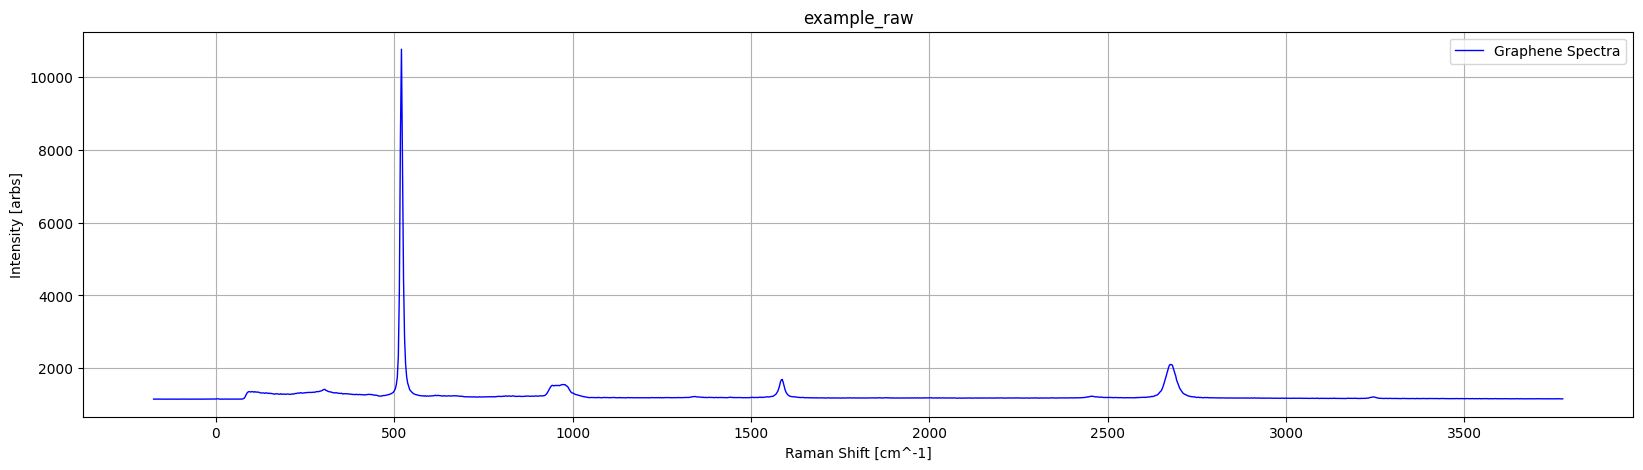

In [4]:
# Graphing
fig0 = plt.figure(figsize=(20,5))
ax = fig0.add_subplot(1,1,1)
ax.plot(df_raw,linewidth=1,label='Graphene Spectra',color='b')
ax.grid()
ax.set_ylabel('Intensity [arbs]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_raw')
ax.legend()
plt.show()

In [5]:
'''
NOISE CLEARING.
To perform proper analysis on the RAMAN spectrum, it is necessary to perform noise cleaning on the raw data.
This cleaning includes silicon spectrum subtraction, analysis range limits, normalization and signal smoothing.
'''
# Spectral Substraction of Silicon
reference_path = 'reference.txt'
df_reference =  pd.read_csv(reference_path, sep='\t', names=['shift','intensity'], index_col = 'shift')
df = df_raw - df_reference

# Shift Range Reduction
upper_bound = 3500
lower_bound = 1000
df = df.loc[lower_bound:upper_bound]

# Normalization
df = abs(df)/df.max()

# Save Clean Data
df.to_csv('example_noiseless.txt',sep='\t', index=True, header = False)

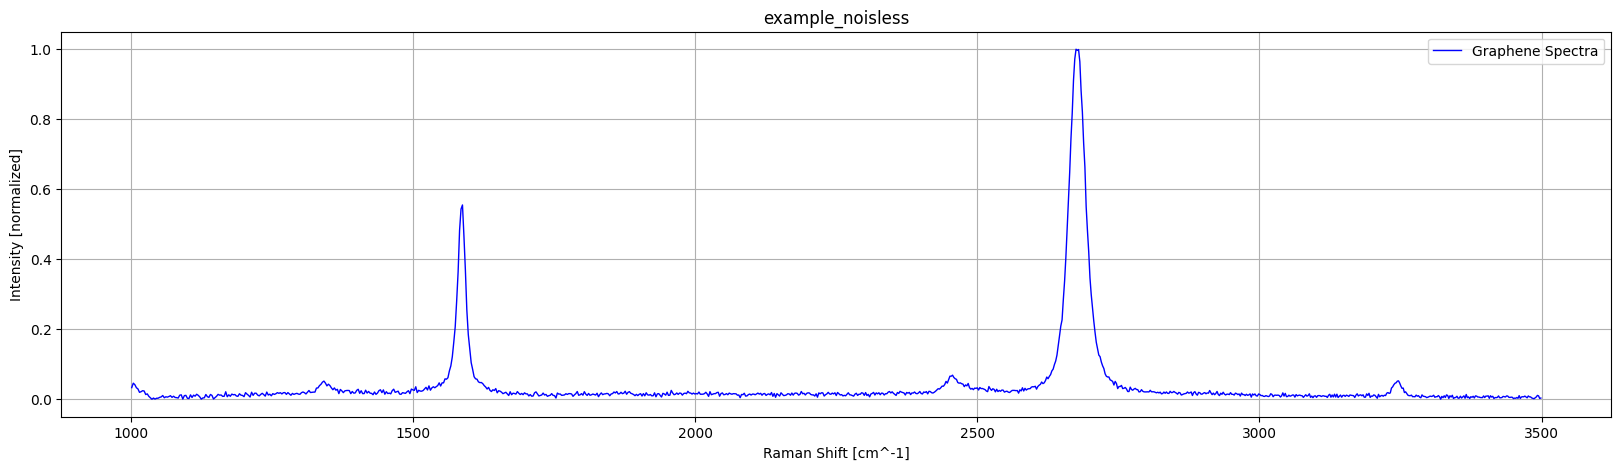

In [6]:
# Graphing
fig1 = plt.figure(figsize=(20,5))
ax = fig1.add_subplot(1,1,1)
ax.plot(df,linewidth=1,label='Graphene Spectra',color='b')
ax.grid()
ax.set_ylabel('Intensity [normalized]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_noisless')
ax.legend()
plt.show()

In [7]:
'''
PEAK FINDING.
'''
# Peak Finding
height = 0.025
prominence = 0.025
distance = None 
p, _ = fp(x=df.intensity,height = height, prominence = prominence, distance = distance)
peaks = df.iloc[p]
n = len(peaks) # total peaks found
print(peaks)

             intensity
shift                 
1342.331753   0.051800
1587.816526   0.555057
2456.170532   0.068675
2674.968818   1.000000
3246.393069   0.052440


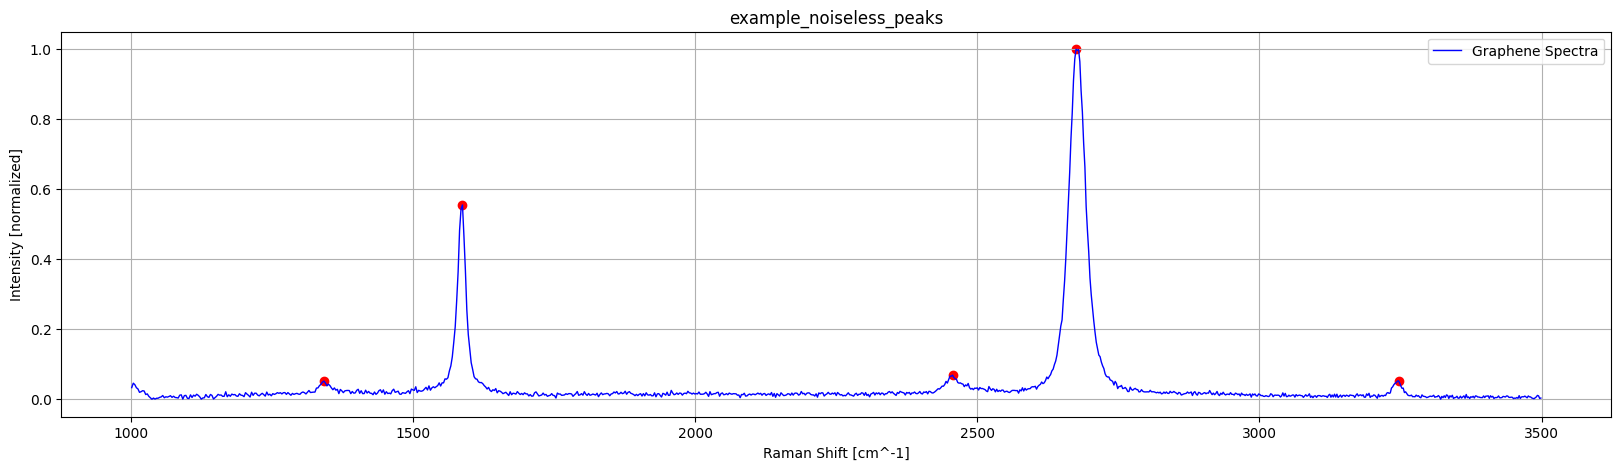

In [8]:
# Graphing
fig2 = plt.figure(figsize=(20,5))
ax = fig2.add_subplot(1,1,1)
ax.plot(df,linewidth=1,label='Graphene Spectra',color='b')
ax.scatter(peaks.index.values,peaks, color='r')
ax.grid()
ax.set_ylabel('Intensity [normalized]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_noiseless_peaks')
ax.legend()
plt.show()

In [13]:
'''
LORENTZ FITTING.
n is the lorentz level, x is the variable, x0 is the array of peak position,
a and gam are the array of A and gamma which represent area and widht of peaks.
'''
def _1lorentz( x, a, gam, i ):
    return a * gam**2 / ( gam**2 + ( x - peaks.index.values[i] )**2)

def _2lorentz( x, a0, gam0, a1, gam1) :
    return a0 * gam0**2 / ( gam0**2 + ( x - peaks.index.values[0] )**2) + a1 * gam1**2 / ( gam1**2 + ( x - peaks.index.values[1] )**2)

def _3lorentz( x, a0, gam0, a1, gam1, a3, gam3):
    return a0 * gam0**2 / ( gam0**2 + ( x - peaks.index.values[0] )**2) + a1 * gam1**2 / ( gam1**2 + ( x - peaks.index.values[1] )**2) + a3* gam3**2 / ( gam3**2 + ( x - peaks.index.values[3] )**2)
xData, yData = np.loadtxt('example_noiseless.txt', unpack=True )
popt, pcov = curve_fit(_3lorentz,xData,yData)
print(popt)

[1.55622399e-02 1.97678933e+03 5.45276286e-01 8.26928934e+00
 1.03690003e+00 1.54221619e+01]


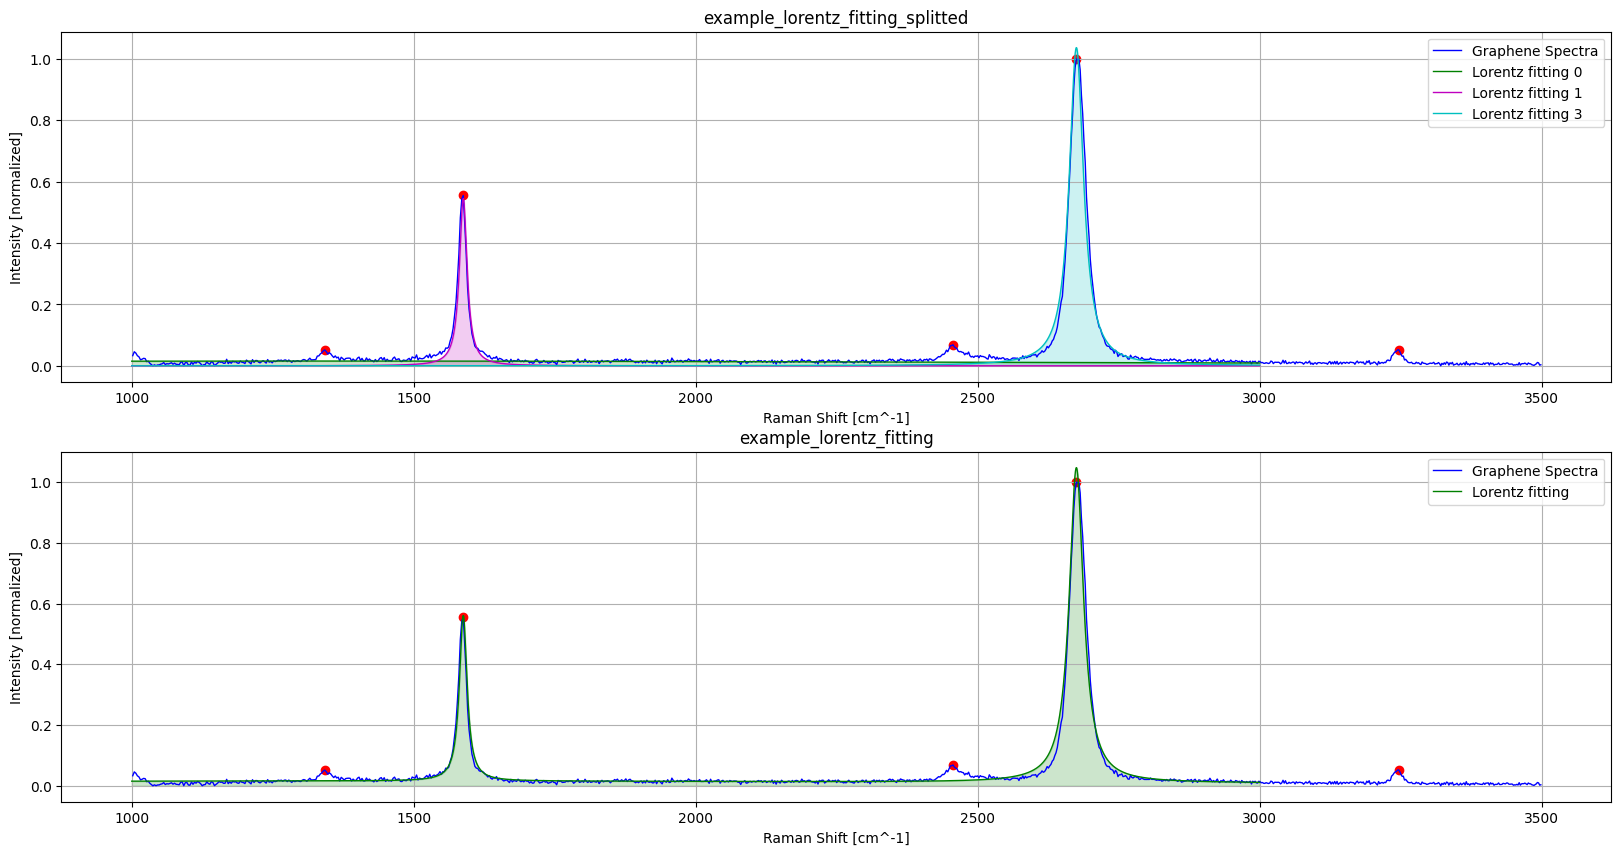

In [12]:
# Graphing
fig3 = plt.figure(figsize=(20,10))
ax = fig3.add_subplot(2,1,1)
bx = fig3.add_subplot(2,1,2)

ax.plot(df,linewidth=1,label='Graphene Spectra',color='b') # experimental data
ax.scatter(peaks.index.values,peaks, color='r') # peaks fitting

bx.plot(df,linewidth=1,label='Graphene Spectra',color='b') # experimental data
bx.scatter(peaks.index.values,peaks, color='r') # peaks fitting

# lorentz fitting
x = np.arange(1000, 3000, 0.01)

ax.plot(x,_1lorentz(x,popt[0],popt[1],0),linewidth=1,label='Lorentz fitting 0',color='g',alpha = 1.0) 
ax.fill_between(x, 0, _1lorentz(x,popt[0],popt[1],0), color='g', alpha=.2)

ax.plot(x,_1lorentz(x,popt[2],popt[3],1),linewidth=1,label='Lorentz fitting 1',color='m',alpha = 1.0) 
ax.fill_between(x, 0, _1lorentz(x,popt[2],popt[3],1), color='m', alpha=.2)

ax.plot(x,_1lorentz(x,popt[4],popt[5],3),linewidth=1,label='Lorentz fitting 3',color='c',alpha = 1.0) 
ax.fill_between(x, 0, _1lorentz(x,popt[4],popt[5],3), color='c', alpha=.2)

bx.plot(x,_3lorentz(x,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]),linewidth=1,label='Lorentz fitting',color='g',alpha = 1.0) 
bx.fill_between(x, 0,_3lorentz(x,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]), color='g', alpha=.2)

ax.grid()
ax.set_ylabel('Intensity [normalized]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_lorentz_fitting_splitted')
ax.legend()

bx.grid()
bx.set_ylabel('Intensity [normalized]')
bx.set_xlabel('Raman Shift [cm^-1]')
bx.set_title(filename + '_lorentz_fitting')
bx.legend()
plt.show()

[[Model]]
    (((((Model(linear, prefix='bkg_') + Model(lorentzian, prefix='lz1_')) + Model(lorentzian, prefix='lz2_')) + Model(lorentzian, prefix='lz3_')) + Model(lorentzian, prefix='lz4_')) + Model(lorentzian, prefix='lz5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3764
    # data points      = 1060
    # variables        = 17
    chi-square         = 0.08619101
    reduced chi-square = 8.2638e-05
    Akaike info crit   = -9948.24640
    Bayesian info crit = -9863.82399
    R-squared          = 0.99317731
[[Variables]]
    bkg_slope:     -4.0845e-06 +/- 4.4655e-07 (10.93%) (init = 1)
    bkg_intercept:  0.01901787 +/- 0.00108860 (5.72%) (init = 0)
    lz1_amplitude:  1.56474977 +/- 0.22854737 (14.61%) (init = 0.05)
    lz1_center:     1344.37582 +/- 2.02355742 (0.15%) (init = 1342.332)
    lz1_sigma:      15.3902895 +/- 3.01555142 (19.59%) (init = 0.5)
    lz1_fwhm:       30.7805790 +/- 6.03110285 (19.59%) == '2.0000000*lz1_sigma'
    lz1_height: 

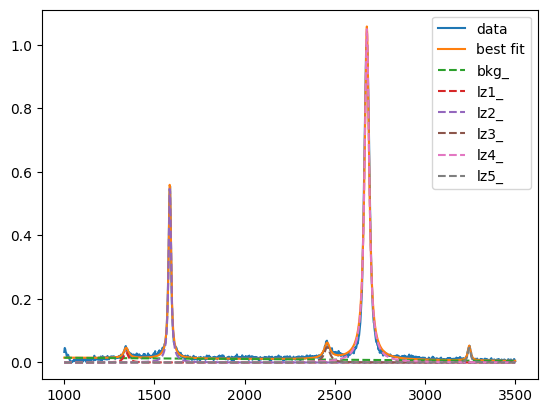

In [24]:
def add_peak(prefix, center, amplitude=0.05, sigma=0.5):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + 'center'].set(center)
    pars[prefix + 'amplitude'].set(amplitude)
    pars[prefix + 'sigma'].set(sigma, min=0)
    return peak, pars

model = LinearModel(prefix='bkg_')
params = model.make_params(a=0, b=0, c=0)

rough_peak_positions = peaks.index.values
for i, cen in enumerate(rough_peak_positions):
    peak, pars = add_peak('lz%d_' % (i+1), cen)
    model = model + peak
    params.update(pars)

init = model.eval(params, x=xData)
result = model.fit(yData, params, x=xData)
comps = result.eval_components()

print(result.fit_report(min_correl=0.5))

plt.plot(xData, yData, label='data')
plt.plot(xData, result.best_fit, label='best fit')
for name, comp in comps.items():
    plt.plot(xData, comp, '--', label=name)
plt.legend(loc='upper right')
plt.show()